# 3D Validation

This notebook loads two meshes; the first obtained from an image reconstruction; the second one obtained from a CT scan. A point cloud sampling takes place for both meshes to aligned them with the ICP algorithm. Once aligned, the Hausdorff distance is calculated.

In [1]:
import os
import open3d as o3d
import pymeshlab 
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import pandas as pd
from open3d.visualization import draw_geometries
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial.distance import dice

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Path  
path = "model_demo/"

try:  
    os.mkdir(path)  
except OSError as error:  
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'model_demo/'


## Calculate the Hausdorff distance 

Obtains the Hausdorff distance for the worst case scenario

In [3]:
# Loading the original mesh
mesh_orig = o3d.io.read_triangle_mesh(path +'Original_studyCase_M1.ply')
mesh_orig.compute_vertex_normals()
mesh_orig.paint_uniform_color((0.0, 0.0, 1.0));

# Loading the reconstructed mesh
mesh_rec = o3d.io.read_triangle_mesh(path +'M1\M1_mesh_poisson.ply')
mesh_rec.compute_vertex_normals()
mesh_rec.paint_uniform_color((0.0, 1.0, 0.0));
# Transformamos para obtener un mejor registro
mesh_rec.scale(1000.0, center=mesh_rec.get_center())
mesh_rec.rotate(mesh_rec.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi)), center=(0, 0, 0))

TriangleMesh with 9358 points and 18716 triangles.

In [4]:
# Sample a point cloud with 20000 points using Poisson sampling.
pts_orig = mesh_orig.sample_points_poisson_disk(number_of_points=20000, init_factor=4)
pts_rec = mesh_rec.sample_points_poisson_disk(number_of_points=20000, init_factor=4)
pts_orig.paint_uniform_color((0.0, 0.0, 1.0));
pts_rec.paint_uniform_color((0.0, 1.0, 0.0));

Before using ICP registration, an initial alignment happens between the two meshes with a rigid transformation.

In [5]:
# A identity homogeneous transformation matrix is created.
mat_init = np.asarray([[1.0, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 0.0],
                       [0.0, 0.0, 1.0, 0.0],
                       [0.0, 0.0, 0.0, 1.0]])

# The ICP point cloud registration takes place.
mat_reg = o3d.pipelines.registration.registration_icp(
    pts_rec, pts_orig, 20.0, mat_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration = 500))

# Geometries are drawn
pts_rec.transform(mat_reg.transformation)
mesh_rec.transform(mat_reg.transformation)
draw_geometries([mesh_rec, mesh_orig])

In [6]:
o3d.io.write_triangle_mesh(path +"copy_of_Original_studyCase_M1.stl", mesh_orig)
o3d.io.write_triangle_mesh(path +"copy_of_M1_mesh_poisson.stl", mesh_rec)

True

In [7]:
mesh1 = o3d.io.read_triangle_mesh(path +'copy_of_Original_studyCase_M1.stl')
mesh1.compute_vertex_normals()
mesh1.paint_uniform_color((0.0, 0.0, 1.0))

mesh2 = o3d.io.read_triangle_mesh(path +'copy_of_M1_mesh_poisson.stl')
mesh2.compute_vertex_normals()
mesh2.paint_uniform_color((0.0, 1.0, 1.0))

draw_geometries([mesh1, mesh2])

In [8]:
# The mesh similarity is measured by using Hausdorff distance
print("Hausdorff:", directed_hausdorff(pts_rec.points, pts_orig.points)[0])

Hausdorff: 11.418940784542796


## Statistics summary

Display the summary report by computing the Root Mean Square, Mean, Median, Interquartiles

In [9]:
# Using pymeshlab to compute statistics
ms = pymeshlab.MeshSet()
ms.load_new_mesh(path +'copy_of_Original_studyCase_M1.stl')
ms.load_new_mesh(path +'copy_of_M1_mesh_poisson.stl')

In [10]:
ms.apply_filter('get_hausdorff_distance', targetmesh=1, sampledmesh=0, savesample = True)

{'RMS': 2.7284488677978516,
 'diag_mesh_0': 251.44259643554688,
 'diag_mesh_1': 240.4421550599154,
 'max': 10.71070384979248,
 'mean': 1.9323740005493164,
 'min': 6.072019914427074e-06,
 'n_samples': 3833}

In [11]:
# Obtain the Hausdorff distance along all vertices
vq = ms.mesh(2).vertex_scalar_array()

# Calculate the root mean squared and mean from the Hausdorff distances
squared = np.square(vq)
avg = np.sum(squared)/len(vq)
rms = np.sqrt(avg)

mean = np.mean(vq)

print('RMS: ', rms)
print('Mean: ', mean)

RMS:  2.728448818525425
Mean:  1.9323740495020343


In [12]:
data = np.sort(vq)
# First quartile (Q1)
Q1 = np.median(data[:1915])

# Second quartile (Q2)
Q2 = np.median(data)

# Third quartile (Q3)
Q3 = np.median(data[1917:])
  
# Interquartile range (IQR)
IQR = Q3 - Q1


print('Median: ', Q2)
print('Interquartile Range: ', IQR)

Median:  1.266014903578693
Interquartile Range:  2.06235222606335


## Plot and Table

Display a histogram of all the Hausdorff distances along the vertices 

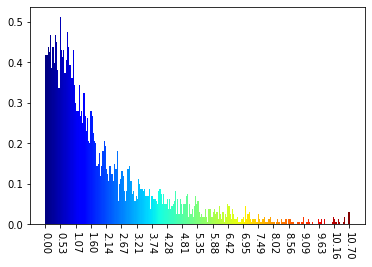

In [13]:
# Create a histogram of all the Hausdorff distances along the vertices

# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('jet')

# Plot histogram.
n, bins, patches = plt.hist(vq, 256, density = True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.xticks(np.linspace(float(format(min(vq), '.1f')),
               float(format(max(vq), '.1f')),
               num = 21,
               endpoint = True))
plt.tick_params(axis ='x', rotation = -90)


output_file = path + "/HD_histogram.svg"
plt.savefig(output_file,
        bbox_inches ="tight",
        transparent = True,
        facecolor ="w",
        edgecolor ='w',
        orientation ='landscape')    
    
plt.show()

# https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
# https://www.geeksforgeeks.org/numpy-linspace-python/
# https://www.geeksforgeeks.org/python-matplotlib-pyplot-ticks/

# https://stackoverflow.com/questions/65371819/meaning-of-hausdorff-distance-results-in-meshlab
# https://stackoverflow.com/questions/58166100/how-to-show-the-heat-map-for-the-hausdorff-distance-in-meshlab
# https://stackoverflow.com/questions/46089463/comparing-models-somebody-can-give-me-an-exmple


In [18]:
df = pd.DataFrame()

df['Min.'] = [format(min(vq), '.2f')]
df['1st Qu.'] = [format(Q1, '.2f')]
df['Median'] = [format(Q2, '.2f')]
df['Mean'] = [format(mean, '.2f')]
df['3rd Qu.'] = [format(Q3, '.2f')]
df['Max.'] = [format(max(vq), '.2f')]
df['IQR'] = [format(IQR, '.2f')]
df['RMS'] = [format(rms, '.2f')]

df

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,IQR,RMS
0,0.00,0.59,1.27,1.93,2.65,10.71,2.06,2.73
